## 1. Import Libraries

In [11]:
import numpy as np

import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

## 2. Display Settings

In [12]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")

In [13]:
import numpy as np
import joblib
import pandas as pd
import sklearn

from pathlib import Path

# Your imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer
)
from sklearn.metrics.pairwise import rbf_kernel

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
)

import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
sklearn.set_config(transform_output="pandas")

# ================
# Custom transformers
# ================

def select_duration(X):
    return X[["duration"]]


def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X.assign(**{
            f"{col}_is_north": X[col].isin(north_cities).astype(int)
            for col in columns
        }).drop(columns=columns)
    )

def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X[col]).dt.hour
        for col in columns
    })
    return X_temp.assign(**{
        f"{col}_part_of_day": np.select(
            [
                X_temp[col].between(morning, noon, inclusive="left"),
                X_temp[col].between(noon, eve, inclusive="left"),
                X_temp[col].between(eve, night, inclusive="left")
            ],
            ["morning", "afternoon", "evening"],
            default="night"
        )
        for col in columns
    }).drop(columns=columns)

class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    def fit(self, X, y=None):
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()
        self.reference_values_ = {
            col: (
                X[col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }
        return self

    def transform(self, X):
        objects = []
        for col in self.variables:
            columns = [f"{col}_rbf_{int(p*100)}" for p in self.percentiles]
            obj = pd.DataFrame(
                data=rbf_kernel(
                    X[[col]],
                    Y=self.reference_values_[col],
                    gamma=self.gamma
                ),
                columns=columns,
                index=X.index
            )
            objects.append(obj)
        return pd.concat(objects, axis=1)

def duration_category(X, short=180, med=400):
    return (
        X.assign(duration_cat=np.select(
            [X.duration.lt(short),
             X.duration.between(short, med, inclusive="left")],
            ["short", "medium"],
            default="long"
        )).drop(columns="duration")
    )

def is_over(X, value=1000):
    return (
        X.assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)
        }).drop(columns="duration")
    )

# ================
# Pipeline components
# ================

def make_air_transformer():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
        ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    ])

def make_doj_transformer():
    return Pipeline([
        ("dt", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_year"], yearfirst=True, format="mixed")),
        ("scaler", MinMaxScaler())
    ])

def make_location_transformer():
    location_pipe1 = Pipeline([
        ("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
        ("encoder", MeanEncoder()),
        ("scaler", PowerTransformer())
    ])
    return FeatureUnion([
        ("part1", location_pipe1),
        ("part2", FunctionTransformer(func=is_north))
    ])

def time_transformer():
    time_pipe1 = Pipeline([
        ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
        ("scaler", MinMaxScaler())
    ])
    time_pipe2 = Pipeline([
        ("part", FunctionTransformer(func=part_of_day)),
        ("encoder", CountFrequencyEncoder()),
        ("scaler", MinMaxScaler())
    ])
    return FeatureUnion([
        ("part1", time_pipe1),
        ("part2", time_pipe2)
    ])

def make_duration_transformer():
    duration_pipe1 = Pipeline([
        ("rbf", RBFPercentileSimilarity()),
        ("scaler", PowerTransformer())
    ])
    duration_pipe2 = Pipeline([
        ("cat", FunctionTransformer(func=duration_category, validate=False)),
        ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
    ])
    part3 = Pipeline([
        ("is_over", FunctionTransformer(func=is_over, validate=False))
    ])
    part4 = Pipeline([
        ("select_duration", FunctionTransformer(select_duration, validate=False)),
        ("scaler", StandardScaler())
    ])
    return Pipeline([
        ("outliers", Winsorizer(capping_method="iqr", fold=1.5, variables=["duration"])),
        ("imputer", SimpleImputer(strategy="median")),
        ("union", FeatureUnion([
            ("part1", duration_pipe1),
            ("part2", duration_pipe2),
            ("part3", part3),
            ("part4", part4)
        ]))
    ])

def make_total_stops_transformer():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("is_direct", FunctionTransformer(func=is_direct))
    ])

def make_info_transformer():
    info_pipe1 = Pipeline([
        ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])
    return Pipeline([
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("union", FeatureUnion([
            ("part1", info_pipe1),
            ("part2", FunctionTransformer(func=have_info, validate=False))
        ]))
    ])

def make_column_transformer():
    return ColumnTransformer([
        ("air", make_air_transformer(), ["airline"]),
        ("doj", make_doj_transformer(), ["date_of_journey"]),
        ("location", make_location_transformer(), ["source", "destination"]),
        ("time", time_transformer(), ["dep_time", "arrival_time"]),
        ("dur", make_duration_transformer(), ["duration"]),
        ("stops", make_total_stops_transformer(), ["total_stops"]),
        ("info", make_info_transformer(), ["additional_info"])
    ], remainder="passthrough")

def make_selector():
    estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
    return SelectBySingleFeaturePerformance(
        estimator=estimator,
        scoring="r2",
        threshold=0.1
    )

def make_preprocessor():
    return Pipeline([
        ("ct", make_column_transformer()),
        ("selector", make_selector())
    ])

# ================
# Main script
# ================

if __name__ == "__main__":
    # Read your data
    df = pd.read_csv(r"C:\Users\manas\OneDrive\Desktop\MLOPS\flight_price_pred\data\processed\train.csv")
    y = df["price"]
    X = df.drop(columns=["price"])

    # Make and fit the preprocessor
    preprocessor = make_preprocessor()
    # preprocessor.set_output(transform="pandas")
    preprocessor.fit(X, y)

    # Save the preprocessor
    output_path = Path(r"C:\Users\manas\OneDrive\Desktop\MLOPS\flight_price_pred\models\preprocessor.joblib")
    joblib.dump(preprocessor, output_path)

    print(f"✅ Preprocessor saved to: {output_path}")


✅ Preprocessor saved to: C:\Users\manas\OneDrive\Desktop\MLOPS\flight_price_pred\models\preprocessor.joblib


## 3. Read the Data

In [14]:
path = r"C:\Users\manas\OneDrive\Desktop\MLOPS\flight_price_pred\data\processed\train.csv"

train = pd.read_csv(path)
train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-15,Delhi,Cochin,05:35:00,08:50:00,195,0.0,No Info,5601
1,Jet Airways,2019-05-09,Delhi,Cochin,10:00:00,19:00:00,540,1.0,No Info,15554
2,Spicejet,2019-05-18,Mumbai,Hyderabad,13:15:00,14:45:00,90,0.0,No Info,2227
3,Indigo,2019-05-06,Kolkata,Banglore,08:10:00,13:00:00,290,1.0,No Info,5069
4,Air India,2019-03-21,Delhi,Cochin,23:00:00,19:15:00,1215,1.0,No Info,6745
...,...,...,...,...,...,...,...,...,...,...
8364,Indigo,2019-06-03,Banglore,Delhi,08:30:00,11:20:00,170,0.0,No Info,4823
8365,Jet Airways,2019-03-21,Banglore,New Delhi,07:00:00,21:20:00,860,1.0,In-flight meal not included,7832
8366,Indigo,2019-04-03,Delhi,Cochin,10:35:00,15:35:00,300,1.0,No Info,5073
8367,Indigo,2019-04-27,Delhi,Cochin,05:35:00,08:50:00,195,0.0,No Info,6015


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          8369 non-null   object 
 1   date_of_journey  8369 non-null   object 
 2   source           8369 non-null   object 
 3   destination      8369 non-null   object 
 4   dep_time         8369 non-null   object 
 5   arrival_time     8369 non-null   object 
 6   duration         8369 non-null   int64  
 7   total_stops      8368 non-null   float64
 8   additional_info  8369 non-null   object 
 9   price            8369 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 654.0+ KB


In [16]:
X_train = train.drop(columns="price")
y_train = train.price.copy()

## 4. Transformation Operations

### 4.1 airline

In [17]:
X_train.airline

0            Indigo
1       Jet Airways
2          Spicejet
3            Indigo
4         Air India
           ...     
8364         Indigo
8365    Jet Airways
8366         Indigo
8367         Indigo
8368    Jet Airways
Name: airline, Length: 8369, dtype: object

In [18]:
air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

air_transformer.fit_transform(X_train.loc[:, ["airline"]]) #.airline.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
8364,0.0,1.0,0.0,0.0,0.0
8365,0.0,0.0,1.0,0.0,0.0
8366,0.0,1.0,0.0,0.0,0.0
8367,0.0,1.0,0.0,0.0,0.0


### 4.2 date_of_journey

In [19]:
X_train.date_of_journey

0       2019-06-15
1       2019-05-09
2       2019-05-18
3       2019-05-06
4       2019-03-21
           ...    
8364    2019-06-03
8365    2019-03-21
8366    2019-04-03
8367    2019-04-27
8368    2019-05-21
Name: date_of_journey, Length: 8369, dtype: object

In [20]:
feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]

doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:, ["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.882353,0.833333,0.898305
1,0.666667,0.588235,0.500000,0.584746
2,0.666667,0.647059,0.833333,0.661017
3,0.666667,0.588235,0.000000,0.559322
4,0.000000,0.176471,0.500000,0.169492
...,...,...,...,...
8364,1.000000,0.823529,0.000000,0.796610
8365,0.000000,0.176471,0.500000,0.169492
8366,0.333333,0.294118,0.333333,0.279661
8367,0.333333,0.470588,0.833333,0.483051


### 4.3 source & destination

In [21]:
X_train.source

0          Delhi
1          Delhi
2         Mumbai
3        Kolkata
4          Delhi
          ...   
8364    Banglore
8365    Banglore
8366       Delhi
8367       Delhi
8368       Delhi
Name: source, Length: 8369, dtype: object

In [22]:
X_train.destination

0          Cochin
1          Cochin
2       Hyderabad
3        Banglore
4          Cochin
          ...    
8364        Delhi
8365    New Delhi
8366       Cochin
8367       Cochin
8368       Cochin
Name: destination, Length: 8369, dtype: object

In [23]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset

,source,destination
0,Delhi,Cochin
1,Delhi,Cochin
2,Mumbai,Hyderabad
3,Kolkata,Banglore
4,Delhi,Cochin
...,...,...
8364,Banglore,Delhi
8365,Banglore,New Delhi
8366,Delhi,Cochin
8367,Delhi,Cochin


In [24]:
location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,1.047743,1.045589
1,1.047743,1.045589
2,-1.878854,-0.811891
3,-0.168387,-0.185396
4,1.047743,1.045589
...,...,...
8364,-0.909358,-1.840173
8365,-0.909358,-0.811891
8366,1.047743,1.045589
8367,1.047743,1.045589


In [25]:
np.union1d(
	X_train.source.unique(),
	X_train.destination.unique()
)

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [26]:
def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)


FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
8364,0,1
8365,0,1
8366,1,0
8367,1,0


In [27]:
location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,1.047743,1.045589,1,0
1,1.047743,1.045589,1,0
2,-1.878854,-0.811891,1,0
3,-0.168387,-0.185396,1,0
4,1.047743,1.045589,1,0
...,...,...,...,...
8364,-0.909358,-1.840173,0,1
8365,-0.909358,-0.811891,0,1
8366,1.047743,1.045589,1,0
8367,1.047743,1.045589,1,0


### 4.4 dep_time & arrival_time

In [28]:
X_train.dep_time

0       05:35:00
1       10:00:00
2       13:15:00
3       08:10:00
4       23:00:00
          ...   
8364    08:30:00
8365    07:00:00
8366    10:35:00
8367    05:35:00
8368    09:40:00
Name: dep_time, Length: 8369, dtype: object

In [29]:
X_train.arrival_time

0       08:50:00
1       19:00:00
2       14:45:00
3       13:00:00
4       19:15:00
          ...   
8364    11:20:00
8365    21:20:00
8366    15:35:00
8367    08:50:00
8368    04:25:00
Name: arrival_time, Length: 8369, dtype: object

In [30]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,05:35:00,08:50:00
1,10:00:00,19:00:00
2,13:15:00,14:45:00
3,08:10:00,13:00:00
4,23:00:00,19:15:00
...,...,...
8364,08:30:00,11:20:00
8365,07:00:00,21:20:00
8366,10:35:00,15:35:00
8367,05:35:00,08:50:00


In [31]:
time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.217391,0.636364,0.347826,0.909091
1,0.434783,0.000000,0.826087,0.000000
2,0.565217,0.272727,0.608696,0.818182
3,0.347826,0.181818,0.565217,0.000000
4,1.000000,0.000000,0.826087,0.272727
...,...,...,...,...
8364,0.347826,0.545455,0.478261,0.363636
8365,0.304348,0.000000,0.913043,0.363636
8366,0.434783,0.636364,0.652174,0.636364
8367,0.217391,0.636364,0.347826,0.909091


In [32]:
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,morning,morning
1,morning,evening
2,afternoon,afternoon
3,morning,afternoon
4,night,evening
...,...,...
8364,morning,morning
8365,morning,night
8366,morning,afternoon
8367,morning,morning


In [33]:
time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,1.000000,0.967337
1,1.000000,0.653266
2,0.000000,0.000000
3,1.000000,0.000000
4,0.155749,0.653266
...,...,...
8364,1.000000,0.967337
8365,1.000000,1.000000
8366,1.000000,0.000000
8367,1.000000,0.967337


In [34]:
time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.217391,0.636364,0.347826,0.909091,1.000000,0.967337
1,0.434783,0.000000,0.826087,0.000000,1.000000,0.653266
2,0.565217,0.272727,0.608696,0.818182,0.000000,0.000000
3,0.347826,0.181818,0.565217,0.000000,1.000000,0.000000
4,1.000000,0.000000,0.826087,0.272727,0.155749,0.653266
...,...,...,...,...,...,...
8364,0.347826,0.545455,0.478261,0.363636,1.000000,0.967337
8365,0.304348,0.000000,0.913043,0.363636,1.000000,1.000000
8366,0.434783,0.636364,0.652174,0.636364,1.000000,0.000000
8367,0.217391,0.636364,0.347826,0.909091,1.000000,0.967337


### 4.5 duration

In [35]:
X_train.duration

0        195
1        540
2         90
3        290
4       1215
        ... 
8364     170
8365     860
8366     300
8367     195
8368    1125
Name: duration, Length: 8369, dtype: int64

In [36]:
(
	X_train
	.duration
	.quantile([0.25, 0.5, 0.75])
	.values
	.reshape(-1, 1)
	# .shape
)

array([[170.],
       [505.],
       [920.]])

In [37]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)
# RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

In [38]:
X_train_clean = X_train.dropna()
RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train_clean)


,duration_rbf_40,duration_rbf_80,total_stops_rbf_40,total_stops_rbf_80
0,0.000000e+00,0.000000e+00,0.904837,0.904837
1,0.000000e+00,0.000000e+00,1.000000,1.000000
2,0.000000e+00,0.000000e+00,0.904837,0.904837
3,3.240271e-184,0.000000e+00,1.000000,1.000000
4,0.000000e+00,0.000000e+00,1.000000,1.000000
...,...,...,...,...
8363,0.000000e+00,0.000000e+00,0.904837,0.904837
8364,0.000000e+00,0.000000e+00,1.000000,1.000000
8365,4.225900e-132,0.000000e+00,1.000000,1.000000
8366,0.000000e+00,0.000000e+00,0.904837,0.904837


In [39]:
# RBFPercentileSimilarity(percentiles=[0.4, 0.8]).fit_transform(X_train)

In [40]:
def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

In [41]:
def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

In [42]:
duration_pipe1 = Pipeline(steps=[
	("rbf", RBFPercentileSimilarity()),
	("scaler", PowerTransformer())
])

duration_pipe2 = Pipeline(steps=[
	("cat", FunctionTransformer(func=duration_category)),
	("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
])

duration_union = FeatureUnion(transformer_list=[
	("part1", duration_pipe1),
	("part2", duration_pipe2),
	("part3", FunctionTransformer(func=is_over)),
	("part4", StandardScaler())
])

duration_transformer = Pipeline(steps=[
	("outliers", Winsorizer(capping_method="iqr", fold=1.5)),
	("imputer", SimpleImputer(strategy="median")),
	("union", duration_union)
])

duration_transformer.fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,-0.362920,-0.112365,-0.088994,1.0,0,-0.878365
1,-0.362920,-0.112365,-0.088994,2.0,0,-0.180866
2,-0.362920,-0.112365,-0.088994,0.0,0,-1.090647
3,-0.362920,-0.112365,-0.088994,1.0,0,-0.686300
4,-0.362920,-0.112365,-0.088994,2.0,1,1.183807
...,...,...,...,...,...,...
8364,3.119468,-0.112365,-0.088994,0.0,0,-0.928908
8365,-0.362920,-0.112365,-0.088994,2.0,0,0.466090
8366,-0.362920,-0.112365,-0.088994,1.0,0,-0.666082
8367,-0.362920,-0.112365,-0.088994,1.0,0,-0.878365


### 4.6 total_stops

In [43]:
X_train.total_stops

0       0.0
1       1.0
2       0.0
3       1.0
4       1.0
       ... 
8364    0.0
8365    1.0
8366    1.0
8367    0.0
8368    2.0
Name: total_stops, Length: 8369, dtype: float64

In [44]:
def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,1.0,0
2,0.0,1
3,1.0,0
4,1.0,0
...,...,...
8364,0.0,1
8365,1.0,0
8366,1.0,0
8367,0.0,1


### 4.7 additional_info

In [45]:
X_train.additional_info

0                           No Info
1                           No Info
2                           No Info
3                           No Info
4                           No Info
                   ...             
8364                        No Info
8365    In-flight meal not included
8366                        No Info
8367                        No Info
8368    In-flight meal not included
Name: additional_info, Length: 8369, dtype: object

In [46]:
info_pipe1 = Pipeline(steps=[
	("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
	("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
8364,0.0,1.0,0.0
8365,1.0,0.0,0.0
8366,0.0,1.0,0.0
8367,0.0,1.0,0.0


In [47]:
def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [48]:
info_union = FeatureUnion(transformer_list=[
	("part1", info_pipe1),
	("part2", FunctionTransformer(func=have_info))
])

In [49]:
info_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
	("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
8364,0.0,1.0,0.0,0
8365,1.0,0.0,0.0,1
8366,0.0,1.0,0.0,0
8367,0.0,1.0,0.0,0


### 4.8 Column Transformer

In [50]:
column_transformer = ColumnTransformer(transformers=[
	("air", air_transformer, ["airline"]),
	("doj", doj_transformer, ["date_of_journey"]),
	("location", location_transformer, ["source", 'destination']),
	("time", time_transformer, ["dep_time", "arrival_time"]),
	("dur", duration_transformer, ["duration"]),
	("stops", total_stops_transformer, ["total_stops"]),
	("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,1.000000,0.882353,0.833333,0.898305,1.047743,1.045589,1,0,0.217391,0.636364,0.347826,0.909091,1.000000,0.967337,-0.362920,-0.112365,-0.088994,1.0,0,-0.878365,0.0,1,0.0,1.0,0.0,0
1,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,1.047743,1.045589,1,0,0.434783,0.000000,0.826087,0.000000,1.000000,0.653266,-0.362920,-0.112365,-0.088994,2.0,0,-0.180866,1.0,0,0.0,1.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.666667,0.647059,0.833333,0.661017,-1.878854,-0.811891,1,0,0.565217,0.272727,0.608696,0.818182,0.000000,0.000000,-0.362920,-0.112365,-0.088994,0.0,0,-1.090647,0.0,1,0.0,1.0,0.0,0
3,0.0,1.0,0.0,0.0,0.0,0.666667,0.588235,0.000000,0.559322,-0.168387,-0.185396,1,0,0.347826,0.181818,0.565217,0.000000,1.000000,0.000000,-0.362920,-0.112365,-0.088994,1.0,0,-0.686300,1.0,0,0.0,1.0,0.0,0
4,1.0,0.0,0.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,1.047743,1.045589,1,0,1.000000,0.000000,0.826087,0.272727,0.155749,0.653266,-0.362920,-0.112365,-0.088994,2.0,1,1.183807,1.0,0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.000000,0.796610,-0.909358,-1.840173,0,1,0.347826,0.545455,0.478261,0.363636,1.000000,0.967337,3.119468,-0.112365,-0.088994,0.0,0,-0.928908,0.0,1,0.0,1.0,0.0,0
8365,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,0.500000,0.169492,-0.909358,-0.811891,0,1,0.304348,0.000000,0.913043,0.363636,1.000000,1.000000,-0.362920,-0.112365,-0.088994,2.0,0,0.466090,1.0,0,1.0,0.0,0.0,1
8366,0.0,1.0,0.0,0.0,0.0,0.333333,0.294118,0.333333,0.279661,1.047743,1.045589,1,0,0.434783,0.636364,0.652174,0.636364,1.000000,0.000000,-0.362920,-0.112365,-0.088994,1.0,0,-0.666082,1.0,0,0.0,1.0,0.0,0
8367,0.0,1.0,0.0,0.0,0.0,0.333333,0.470588,0.833333,0.483051,1.047743,1.045589,1,0,0.217391,0.636364,0.347826,0.909091,1.000000,0.967337,-0.362920,-0.112365,-0.088994,1.0,0,-0.878365,0.0,1,0.0,1.0,0.0,0


## 5. Feature Selection

In [51]:
estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
) 

## 6. Putting it all Together

In [52]:
preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])

preprocessor.fit_transform(X_train,y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_Other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,0.882353,0.898305,1.047743,1.045589,-0.362920,1.0,0,-0.878365,0.0,1
1,0.0,1.0,0.0,0.588235,0.584746,1.047743,1.045589,-0.362920,2.0,0,-0.180866,1.0,0
2,0.0,0.0,1.0,0.647059,0.661017,-1.878854,-0.811891,-0.362920,0.0,0,-1.090647,0.0,1
3,1.0,0.0,0.0,0.588235,0.559322,-0.168387,-0.185396,-0.362920,1.0,0,-0.686300,1.0,0
4,0.0,0.0,0.0,0.176471,0.169492,1.047743,1.045589,-0.362920,2.0,1,1.183807,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,1.0,0.0,0.0,0.823529,0.796610,-0.909358,-1.840173,3.119468,0.0,0,-0.928908,0.0,1
8365,0.0,1.0,0.0,0.176471,0.169492,-0.909358,-0.811891,-0.362920,2.0,0,0.466090,1.0,0
8366,1.0,0.0,0.0,0.294118,0.279661,1.047743,1.045589,-0.362920,1.0,0,-0.666082,1.0,0
8367,1.0,0.0,0.0,0.470588,0.483051,1.047743,1.045589,-0.362920,1.0,0,-0.878365,0.0,1


## 7. Visualizations

In [53]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.0024826139498357693,
 'air__airline_Indigo': 0.12780896063762226,
 'air__airline_Jet Airways': 0.18511580187225354,
 'air__airline_Multiple Carriers': 0.019922153537647997,
 'air__airline_Other': 0.11498246839107118,
 'doj__date_of_journey_month': 0.08503700579016837,
 'doj__date_of_journey_week': 0.18183419474628723,
 'doj__date_of_journey_day_of_week': 0.004533133710235153,
 'doj__date_of_journey_day_of_year': 0.22369009214479987,
 'location__source': 0.12500642064539078,
 'location__destination': 0.1288919539260215,
 'location__source_is_north': 0.031172271649622108,
 'location__destination_is_north': 0.031172271649622108,
 'time__dep_time_hour': 0.013100017930679534,
 'time__dep_time_minute': 0.03828942446547231,
 'time__arrival_time_hour': 0.06872500403062849,
 'time__arrival_time_minute': 0.03682874599323919,
 'time__dep_time_part_of_day': 1.392698353878489e-05,
 'time__arrival_time_part_of_day': 0.03169550646222211,
 'dur__duration_rbf_25': 0.1100732

In [54]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1]))
sorted_feat_imp

{'dur__duration_rbf_75': -0.001064542956377294,
 'info__additional_info_No Info': -0.0008576243738280809,
 'info__additional_info': -0.0008576243738280809,
 'time__dep_time_part_of_day': 1.392698353878489e-05,
 'info__additional_info_In-flight meal not included': 0.0019020926657356367,
 'air__airline_Air India': 0.0024826139498357693,
 'doj__date_of_journey_day_of_week': 0.004533133710235153,
 'dur__duration_rbf_50': 0.005302619692610071,
 'time__dep_time_hour': 0.013100017930679534,
 'info__additional_info_Other': 0.013990080731083729,
 'air__airline_Multiple Carriers': 0.019922153537647997,
 'location__source_is_north': 0.031172271649622108,
 'location__destination_is_north': 0.031172271649622108,
 'time__arrival_time_part_of_day': 0.03169550646222211,
 'time__arrival_time_minute': 0.03682874599323919,
 'time__dep_time_minute': 0.03828942446547231,
 'time__arrival_time_hour': 0.06872500403062849,
 'doj__date_of_journey_month': 0.08503700579016837,
 'dur__duration_rbf_25': 0.110073238

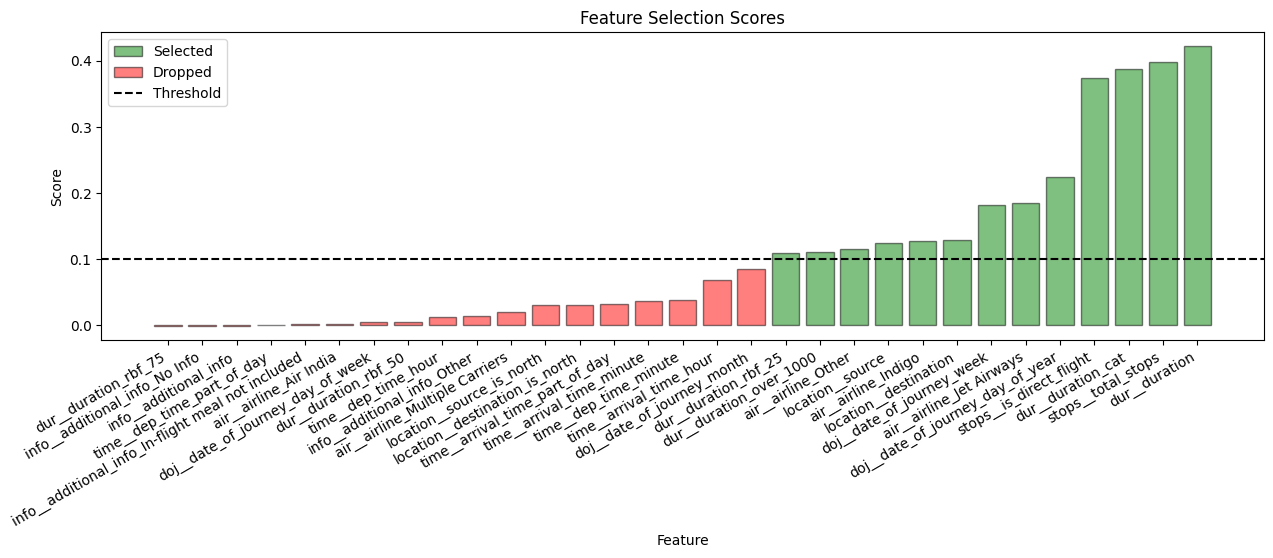

In [55]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]


fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
	params = dict(
		x=i,
		height=score,
		edgecolor="black",
		alpha=0.5
	)
	
	if score < THRESHOLD:
		bar = ax.bar(
			color="red",
			**params
		)
		if not dropped_bar:
			dropped_bar = bar[0]
	else:
		bar = ax.bar(
			color="green",
			**params
		)
		if not selected_bar:
			selected_bar = bar[0]

thresh_line = ax.axhline(
	y=0.1,
	color="black",
	linestyle="--"
)

ax.set_xticks(
	ticks=range(len(sorted_feat_imp)),
	labels=list(sorted_feat_imp.keys()),
	rotation=30,
	ha="right"
)

ax.set(
	xlabel="Feature",
	ylabel="Score",
	title="Feature Selection Scores"
)

ax.legend(
	handles=[selected_bar, dropped_bar, thresh_line],
	labels=["Selected", "Dropped", "Threshold"],
	loc="upper left"
)

plt.show()

- The dataset went upto 31 columns after Feature Engineering
- The Feature Selection algorithm selected 13 features out of that

In [56]:
path = r"C:\Users\manas\OneDrive\Desktop\MLOPS\flight_price_pred\data\processed\train.csv"

In [57]:
import numpy as np
import joblib
import pandas as pd

import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
	OneHotEncoder,
	OrdinalEncoder,
	StandardScaler,
	MinMaxScaler,
	PowerTransformer,
	FunctionTransformer
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.encoding import (
	RareLabelEncoder,
	MeanEncoder,
	CountFrequencyEncoder
)

import matplotlib.pyplot as plt

import warnings

def is_direct(X):
	return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))

def have_info(X):
	return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

def is_north(X):
	columns = X.columns.to_list()
	north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
	return (
		X
		.assign(**{
			f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
			for col in columns
		})
		.drop(columns=columns)
	)

def part_of_day(X, morning=4, noon=12, eve=16, night=20):
	columns = X.columns.to_list()
	X_temp = X.assign(**{
		col: pd.to_datetime(X.loc[:, col]).dt.hour
		for col in columns
	})

	return (
		X_temp
		.assign(**{
			f"{col}_part_of_day": np.select(
				[X_temp.loc[:, col].between(morning, noon, inclusive="left"),
				 X_temp.loc[:, col].between(noon, eve, inclusive="left"),
				 X_temp.loc[:, col].between(eve, night, inclusive="left")],
				["morning", "afternoon", "evening"],
				default="night"
			)
			for col in columns
		})
		.drop(columns=columns)
	)

class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
	def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
		self.variables = variables
		self.percentiles = percentiles
		self.gamma = gamma


	def fit(self, X, y=None):
		if not self.variables:
			self.variables = X.select_dtypes(include="number").columns.to_list()

		self.reference_values_ = {
			col: (
				X
				.loc[:, col]
				.quantile(self.percentiles)
				.values
				.reshape(-1, 1)
			)
			for col in self.variables
		}

		return self


	def transform(self, X):
		objects = []
		for col in self.variables:
			columns = [f"{col}_rbf_{int(percentile * 100)}" for percentile in self.percentiles]
			obj = pd.DataFrame(
				data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
				columns=columns
			)
			objects.append(obj)
		return pd.concat(objects, axis=1)

def duration_category(X, short=180, med=400):
	return (
		X
		.assign(duration_cat=np.select([X.duration.lt(short),
									    X.duration.between(short, med, inclusive="left")],
									   ["short", "medium"],
									   default="long"))
		.drop(columns="duration")
	)

def is_over(X, value=1000):
	return (
		X
		.assign(**{
			f"duration_over_{value}": X.duration.ge(value).astype(int)
		})
		.drop(columns="duration")
	)

def make_air_transformer():
    air_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    ])
    return air_transformer


def make_doj_transformer():
    feature_to_extract = ["month", "week", "day_of_week", "day_of_year"]
    doj_transformer = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True, format="mixed")),
	("scaler", MinMaxScaler())
    ])
    return doj_transformer

def make_location_transformer():
    location_pipe1 = Pipeline(steps=[
	("grouper", RareLabelEncoder(tol=0.1, replace_with="Other", n_categories=2)),
	("encoder", MeanEncoder()),
	("scaler", PowerTransformer())
    ])
    location_transformer = FeatureUnion(transformer_list=[
	("part1", location_pipe1),
	("part2", FunctionTransformer(func=is_north))
    ])
    return location_transformer


def time_transformer():    
    time_pipe1 = Pipeline(steps=[
	("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
	("scaler", MinMaxScaler())])
     
    time_pipe2 = Pipeline(steps=[
	("part", FunctionTransformer(func=part_of_day)),
	("encoder", CountFrequencyEncoder()),
	("scaler", MinMaxScaler())])

    time_transformer = FeatureUnion(transformer_list=[
	("part1", time_pipe1),
	("part2", time_pipe2)
    ])
    return time_transformer


def make_duration_tranformer():
    duration_pipe1 = Pipeline(steps=[
        ("rbf", RBFPercentileSimilarity()),
        ("scaler", PowerTransformer())
    ])
    duration_pipe2 = Pipeline(steps=[
        ("cat", FunctionTransformer(func=duration_category, validate=False)),  
        ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))
    ])

    part3 = Pipeline(steps=[
        ("is_over", FunctionTransformer(func=is_over, validate=False))  
    ])
    part4 = Pipeline(steps=[
        ("select_duration", FunctionTransformer(lambda X: X[["duration"]], validate=False)),
        ("scaler", StandardScaler())
    ])
    duration_union = FeatureUnion(transformer_list=[
        ("part1", duration_pipe1),
        ("part2", duration_pipe2),
        ("part3", part3),
        ("part4", part4)
    ])
    duration_transformer = Pipeline(steps=[
        ("outliers", Winsorizer(capping_method="iqr", fold=1.5, variables=["duration"])),
        ("imputer", SimpleImputer(strategy="median")),
        ("union", duration_union)
    ])

    return duration_transformer

def make_total_stops_tranaformers():
	total_stops_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("", FunctionTransformer(func=is_direct))
	])
	return total_stops_transformer


def make_info_transformer():
    info_pipe1 = Pipeline(steps=[
        ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
        ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ])

    info_union = FeatureUnion(transformer_list=[
        ("part1", info_pipe1),
        ("part2", FunctionTransformer(func=have_info, validate=False))
    ])

    info_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
        ("union", info_union)
    ])

    return info_transformer

def make_column_transformer():
    air = make_air_transformer()
    doj = make_doj_transformer()
    location = make_location_transformer()
    time = time_transformer()
    duration = make_duration_tranformer()
    stops = make_total_stops_tranaformers()
    info = make_info_transformer()

    column_transformer = ColumnTransformer(
        transformers=[
            ("air", air, ["airline"]),
            # ("doj", doj, ["date_of_journey"]),
            ("location", location, ["source", "destination"]),
            ("time", time, ["dep_time", "arrival_time"]),
            ("dur", duration, ["duration"]),
            ("stops", stops, ["total_stops"]),
            ("info", info, ["additional_info"])
        ],
        remainder="passthrough"
    )

    return column_transformer

def make_selector():
	estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)
	selector = SelectBySingleFeaturePerformance(
	estimator=estimator,
	scoring="r2",
	threshold=0.1
	)
	return selector

def make_preprocessor():
	column_transformer = make_column_transformer()
	selector = make_selector()
	preprocessor = Pipeline(steps=[
	("ct", column_transformer),
	("selector", selector)
])
	return preprocessor 
	
def read_dataframe(path):
    df = pd.read_csv(path)
    return df

def save_dataframe(dataframe:pd.DataFrame, save_path):
    dataframe.to_csv(save_path,index=False)

def train_preprocessor(data : pd.DataFrame):
	preprocessor = make_preprocessor()
	preprocessor.set_output(transform='pandas')
	preprocessor.fit(data)
	return preprocessor

def transform_data(transformer,data:pd.DataFrame):
    data_transformed = transformer.transform(data)
    
    return data_transformed

def save_transformer(path,object):
    joblib.dump(value=object,
                filename=path)

def read_dataframe(path):
    df = pd.read_csv(path)
    return df

def save_dataframe(dataframe:pd.DataFrame, save_path):
    dataframe.to_csv(save_path,index=False)

df = pd.read_csv(r"C:\Users\manas\OneDrive\Desktop\MLOPS\flight_price_pred\data\processed\train.csv")
y = df['price']
X = df.drop(columns=['price'])
preprocessor = make_preprocessor()
preprocessor.fit(X,y)

,steps,"[('ct', ...), ('selector', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('air', ...), ('location', ...), ...]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [58]:
import joblib
import sys
import pandas as pd
from yaml import safe_load
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from pathlib import Path
from loguru import logger  # ✅ added loguru
# sys.path.append(str(Path(__file__).resolve().parent.parent))

# PROJ_ROOT = Path(__file__).resolve().parents[1]
# DATA_DIR = PROJ_ROOT / "data"

TARGET = 'price'

# ✅ Set up logger to also log to a file (optional)
# logger.add("logs/train_model.log", rotation="500 KB", retention="10 days", enqueue=True)

def load_dataframe(path):
    logger.info(f"Loading data from {path}")
    df = pd.read_csv(path)
    logger.debug(f"Data shape: {df.shape}")
    return df

def make_X_y(dataframe: pd.DataFrame, target_column: str):
    logger.info(f"Splitting dataframe into features and target '{target_column}'")
    df_copy = dataframe.copy()
    X = df_copy.drop(columns=target_column)
    y = df_copy[target_column]
    logger.debug(f"Feature shape: {X.shape}, Target shape: {y.shape}")
    return X, y

def train_model(model, X_train, y_train):
    logger.info(f"Training model: {model.__class__.__name__}")
    model.fit(X_train, y_train)
    logger.success("Model training complete")
    return model

def save_model(model, save_path):
    logger.info(f"Saving model to {save_path}")
    joblib.dump(value=model, filename=save_path)
    logger.success("Model saved")



In [59]:
logger.info("Training pipeline started")

training_data_path = r'C:\Users\manas\OneDrive\Desktop\MLOPS\flight_price_pred\data\processed\final\train.csv'
train_data = pd.read_csv(training_data_path)
X_train, y_train = make_X_y(dataframe=train_data, target_column=TARGET)

# regressor = XGBRegressor()
# regressor = train_model(model=regressor, X_train=X_train, y_train=y_train)

# model_output_path = PROJ_ROOT / 'models' / 'models'
# model_output_path.mkdir(parents=True, exist_ok=True)
    
# save_model(model=regressor, save_path=model_output_path / 'xgbreg.joblib')

2025-07-04 17:25:50.646 | INFO     | __main__:<module>:1 - Training pipeline started
2025-07-04 17:25:50.680 | INFO     | __main__:make_X_y:26 - Splitting dataframe into features and target 'price'


KeyError: "['price'] not found in axis"